In [68]:
import pandas as pd
import numpy as np
import glob

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


In [69]:
files = glob.glob("*.csv")

data = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)

print("Rows:", len(data))
data.head()


Rows: 21600


,timestamp,household_id,usage_liters,household_size,day_of_week,month
0,2025-01-01 00:00:00,H10,2.08,2,Wednesday,January
1,2025-01-01 01:00:00,H10,0.38,2,Wednesday,January
2,2025-01-01 02:00:00,H10,0.72,2,Wednesday,January
3,2025-01-01 03:00:00,H10,2.07,2,Wednesday,January
4,2025-01-01 04:00:00,H10,2.11,2,Wednesday,January


In [70]:
data = data.drop_duplicates()
data = data.dropna()


In [72]:
data["timestamp"] = pd.to_datetime(
    data["timestamp"],
    format="mixed",
    errors="coerce"
)


In [73]:
data["timestamp"].isna().sum()


np.int64(0)

In [74]:
data[data["timestamp"].isna()].head()


,timestamp,household_id,usage_liters,household_size,day_of_week,month


In [75]:
data["hour"] = data["timestamp"].dt.hour
data["day"] = data["timestamp"].dt.day
data["month_num"] = data["timestamp"].dt.month
data["weekday_num"] = data["timestamp"].dt.weekday


In [76]:
data["is_peak"] = (
    ((data["hour"] >= 5) & (data["hour"] <= 9)) |
    ((data["hour"] >= 16) & (data["hour"] <= 21))
).astype(int)


In [77]:
data["hour_sin"] = np.sin(2*np.pi*data["hour"]/24)
data["hour_cos"] = np.cos(2*np.pi*data["hour"]/24)


In [78]:
data = data.sort_values(["household_id","timestamp"])


In [79]:
data["lag1"] = data.groupby("household_id")["usage_liters"].shift(1)
data["lag2"] = data.groupby("household_id")["usage_liters"].shift(2)
data["lag3"] = data.groupby("household_id")["usage_liters"].shift(3)

data["roll3"] = (
    data.groupby("household_id")["usage_liters"]
    .rolling(3).mean()
    .reset_index(level=0, drop=True)
)


In [80]:
data = data.dropna()


In [81]:
data_model = data.drop(
    columns=["timestamp","day_of_week","month"]
)


In [82]:
X = data_model.drop(columns=["usage_liters"])
y = data_model["usage_liters"]


In [83]:
split_index = int(len(X)*0.8)

X_train = X.iloc[:split_index]
X_test  = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test  = y.iloc[split_index:]


In [85]:
X = pd.get_dummies(X, columns=["household_id"], drop_first=True)


In [86]:
split_index = int(len(X)*0.8)

X_train = X.iloc[:split_index]
X_test  = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test  = y.iloc[split_index:]


In [87]:
rf.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",500
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",20
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",2
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples 

In [88]:
gb = HistGradientBoostingRegressor(max_depth=12)

gb.fit(X_train, y_train)

gb_pred = gb.predict(X_test)


In [90]:
print("GB R2:", r2_score(y_test, gb_pred))
print("GB MSE:", mean_squared_error(y_test, gb_pred))

GB R2: 0.9887616016972762
GB MSE: 26.650337237092902


In [91]:
feat_imp = pd.DataFrame({
    "feature": X.columns,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)

feat_imp.head(10)


,feature,importance
11,roll3,0.731387
5,is_peak,0.145765
7,hour_cos,0.041541
1,hour,0.033386
9,lag2,0.020581
6,hour_sin,0.011204
8,lag1,0.010397
10,lag3,0.003729
2,day,0.000776
4,weekday_num,0.000392


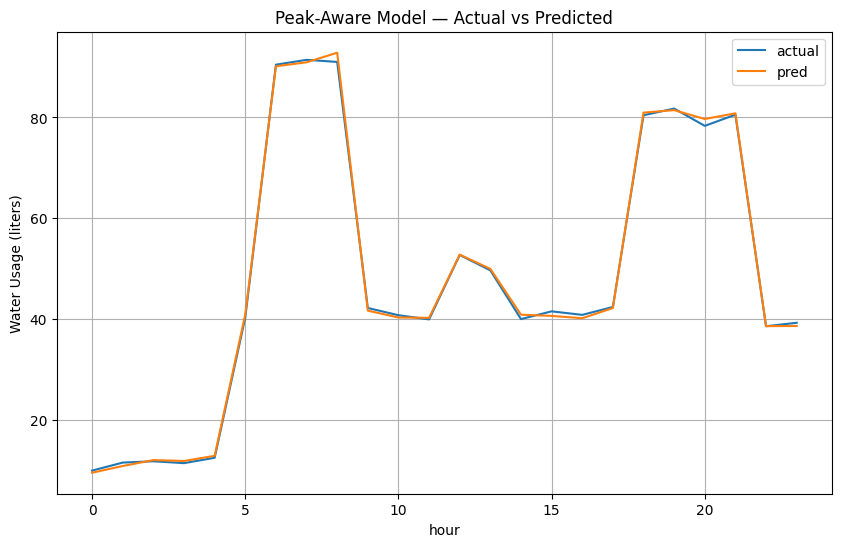

In [92]:
plot_df = X_test.copy()
plot_df["actual"] = y_test.values
plot_df["pred"] = gb_pred

hour_avg = plot_df.groupby("hour")[["actual","pred"]].mean()

hour_avg.plot(figsize=(10,6))
plt.title("Peak-Aware Model — Actual vs Predicted")
plt.ylabel("Water Usage (liters)")
plt.grid(True)
plt.show()
